In [20]:
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score


In [21]:
# đọc dữ liệu từ file CSV
df = pd.read_csv("dataset.csv")

if "Date" in df.columns:
    df = df.drop(columns=["Date"])

# Xác định cột doanh thu (target liên tục)
target = "Revenue_(USD)"
if target not in df.columns:
    candidates = [c for c in df.columns if "revenue" in c.lower()]
    if not candidates:
        raise ValueError("Không tìm thấy cột doanh thu (vd: 'Revenue_(USD)').")
    target = candidates[0]

print("\n🔹 Thống kê mô tả từng cột:")
display(df.describe().T.round(5))


🔹 Thống kê mô tả từng cột:


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1132.0,1.6272,3.2584e-01,1.0000,1.4269,1.5568,1.7912,2.6158e+00
Unique_viewers,1132.0,25396.7261,5.4910e+04,8.0000,457.5000,4115.0000,18102.5000,4.8225e+05
Click_rate_(%),1132.0,6.5686,2.2467e+00,3.5200,5.1675,6.1100,7.1225,2.3140e+01
Impressions,1132.0,833559.0945,1.8787e+06,44.0000,8469.0000,68862.0000,398580.7500,1.6324e+07
Comments,1132.0,224.1193,7.3701e+02,0.0000,2.0000,28.0000,128.2500,1.1582e+04
Shares,1132.0,123.0362,3.3398e+02,0.0000,2.0000,22.0000,87.0000,6.5130e+03
Dislikes,1132.0,39.3949,8.1494e+01,0.0000,0.7500,6.0000,31.0000,6.6400e+02
Likes,1132.0,2788.8401,7.4686e+03,0.0000,15.0000,257.5000,1246.2500,6.3543e+04
Average_viewed_(%),1132.0,28.7774,6.1366e+00,10.9500,24.2275,28.0950,32.5500,6.2190e+01
Videos_published,1132.0,0.1511,4.5985e-01,0.0000,0.0000,0.0000,0.0000,4.0000e+00


## 1. Xử lý dữ liệu

In [22]:
def clean_val(v):
    if pd.isna(v): return np.nan
    if isinstance(v, (int, float)): return v
    s = str(v).strip()
    if s.endswith("%"):
        s = s[:-1]
        s = s.replace(",", "").replace("$","").replace("\u00a0","")
        num = pd.to_numeric(s, errors="coerce")
        return num/100.0 if pd.notna(num) else np.nan
    s = s.replace(",", "").replace("$","").replace("\u00a0","")
    return pd.to_numeric(s, errors="coerce")

for c in df.select_dtypes(include=["object"]).columns:
    sample = df[c].dropna().astype(str).head(20).tolist()
    if any(re.search(r"[\d$,%]", s) for s in sample):
        df[c] = df[c].map(clean_val)

In [23]:
# Chuẩn bị dữ liệu đặc trưng (X) và mục tiêu (y)
X_df = df.drop(columns=[target], errors="ignore").select_dtypes(include=[np.number]).copy()
y_cont = pd.to_numeric(df[target], errors="coerce")

xy = pd.concat([X_df, y_cont.rename(target)], axis=1).dropna()
X_df = xy.drop(columns=[target])
y_cont = xy[target]

# Tạo nhãn từ doanh thu
try:
    labels = pd.qcut(y_cont, q=4, labels=["Low","MidLow","MidHigh","High"], duplicates="drop")
except Exception:
    labels = pd.qcut(y_cont, q=2, labels=["Low","High"], duplicates="drop")
y = labels.astype(str).to_numpy()

## 2. Khởi tạo mô hình và thước đo

In [24]:
# Định nghĩa mô hình
pipelines = {
    "PCA+LogReg (0.95 var)": Pipeline([
        ("sc", StandardScaler()),
        ("pca", PCA(n_components=0.95, svd_solver="full")),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "LDA (svd)": Pipeline([
        ("sc", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis())
    ]),
    "LDA (shrinkage)": Pipeline([
        ("sc", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))
    ]),
}

In [25]:
# Định nghĩa thước đo đánh giá mô hình
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro"),
    "bal_acc": make_scorer(balanced_accuracy_score),
}

## 3.Tổng hợp kết quả và đưa ra kêt luận

In [26]:
# Tong hợp kết quả đánh giá mô hình
rows = []
for name, pipe in pipelines.items():
    res = cross_validate(pipe, X_df.values, y, cv=cv, scoring=scoring, return_train_score=False)
    rows.append({
        "Model": name,
        "ACC_mean":  np.mean(res["test_accuracy"]),
        "ACC_std":   np.std(res["test_accuracy"]),
        "F1m_mean":  np.mean(res["test_f1_macro"]),
        "F1m_std":   np.std(res["test_f1_macro"]),
        "BalAcc_mean": np.mean(res["test_bal_acc"]),
        "BalAcc_std":  np.std(res["test_bal_acc"]),
    })

report = pd.DataFrame(rows).sort_values(by=["F1m_mean","BalAcc_mean","ACC_mean"], ascending=False).reset_index(drop=True)

In [27]:
# In kết quả đánh giá mô hình
pd.set_option("display.precision", 4)
print("\n=== PCA vs LDA (5-fold CV) ===")
print(report.to_string(index=False))

best = report.iloc[0]
winner = best["Model"]
reason = f"ưu tiên F1-macro cao nhất ({best['F1m_mean']:.4f}); tie-break bằng Balanced Accuracy ({best['BalAcc_mean']:.4f}) và Accuracy ({best['ACC_mean']:.4f})."

print("\n>>> Kết luận: Mô hình phù hợp hơn cho bộ dữ liệu hiện tại:", winner)
print("    Lý do:", reason)



=== PCA vs LDA (5-fold CV) ===
                Model  ACC_mean  ACC_std  F1m_mean  F1m_std  BalAcc_mean  BalAcc_std
PCA+LogReg (0.95 var)    0.7359   0.0404    0.7390   0.0389       0.7360      0.0408
            LDA (svd)    0.7032   0.0234    0.7062   0.0227       0.7032      0.0236
      LDA (shrinkage)    0.6953   0.0335    0.6978   0.0323       0.6953      0.0337

>>> Kết luận: Mô hình phù hợp hơn cho bộ dữ liệu hiện tại: PCA+LogReg (0.95 var)
    Lý do: ưu tiên F1-macro cao nhất (0.7390); tie-break bằng Balanced Accuracy (0.7360) và Accuracy (0.7359).


## 4. TRỰC QUAN HOÁ SO SÁNH PCA vs LDA

### 4.1 Chuẩn bị dữ liệu cho việc mô hình hóa

In [28]:
# Tạo train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X_df.values, y, test_size=0.25, random_state=42, stratify=y
)

# Chuẩn hoá dữ liệu
scaler_viz = StandardScaler()
X_train_scaled = scaler_viz.fit_transform(X_train)
X_test_scaled  = scaler_viz.transform(X_test)

In [29]:
# Fit LDA trên train
n_comp = min(2, np.unique(y_train).size - 1)
lda_viz = LinearDiscriminantAnalysis(n_components=max(1, n_comp))
X_train_lda = lda_viz.fit_transform(X_train_scaled, y_train)

# PCA 2D trên train
pca_viz = PCA(n_components=2)
X_train_pca = pca_viz.fit_transform(X_train_scaled)

# Mã hoá nhãn 
y_codes, y_uniques = pd.factorize(y_train)

### 4.2.Mô hình hóa dữ liệu

#### 4.2.1 Khởi tạo biểu đồ

In [ ]:
# subplot: PCA vs LDA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PCA subplot
sc1 = ax1.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=y_codes, cmap='viridis', alpha=0.7, edgecolor='k', linewidths=0.3
)
evr_pca = float(np.sum(pca_viz.explained_variance_ratio_))
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title(f'PCA Transformation\nExplained Variance: {evr_pca:.2%}')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Class')
cbar1.set_ticks(range(len(y_uniques)))
cbar1.set_ticklabels([str(c) for c in y_uniques])

In [ ]:
# LDA subplot
evr_lda = getattr(lda_viz, "explained_variance_ratio_", None)
evr_lda_sum = float(np.sum(evr_lda)) if evr_lda is not None else np.nan

if X_train_lda.ndim == 2 and X_train_lda.shape[1] >= 2:
    sc2 = ax2.scatter(
        X_train_lda[:, 0], X_train_lda[:, 1],
        c=y_codes, cmap='viridis', alpha=0.7, edgecolor='k', linewidths=0.3
    )
    ax2.set_xlabel('First Linear Discriminant')
    ax2.set_ylabel('Second Linear Discriminant')
    title_lda = 'LDA Transformation'
    title_lda += f"\nExplained Variance: {evr_lda_sum:.2%}" if not np.isnan(evr_lda_sum) else ""
    ax2.set_title(title_lda)
    ax2.grid(True, alpha=0.3)
    cbar2 = plt.colorbar(sc2, ax=ax2)
    cbar2.set_label('Class')
    cbar2.set_ticks(range(len(y_uniques)))
    cbar2.set_ticklabels([str(c) for c in y_uniques])
else:
    # Trường hợp chỉ có 1 thành phần LDA
    for code, cls in enumerate(y_uniques):
        idx = np.where(y_codes == code)[0]
        ax2.scatter(
            X_train_lda[idx, 0], np.zeros_like(idx),
            label=str(cls), alpha=0.7, edgecolor='k', linewidths=0.3
        )
    ax2.set_yticks([])
    ax2.set_xlabel('First Linear Discriminant')
    title_lda = 'LDA Transformation (1D)'
    title_lda += f"\nExplained Variance: {evr_lda_sum:.2%}" if not np.isnan(evr_lda_sum) else ""
    ax2.set_title(title_lda)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Class', frameon=True)

#### 4.2.2. Kết luận

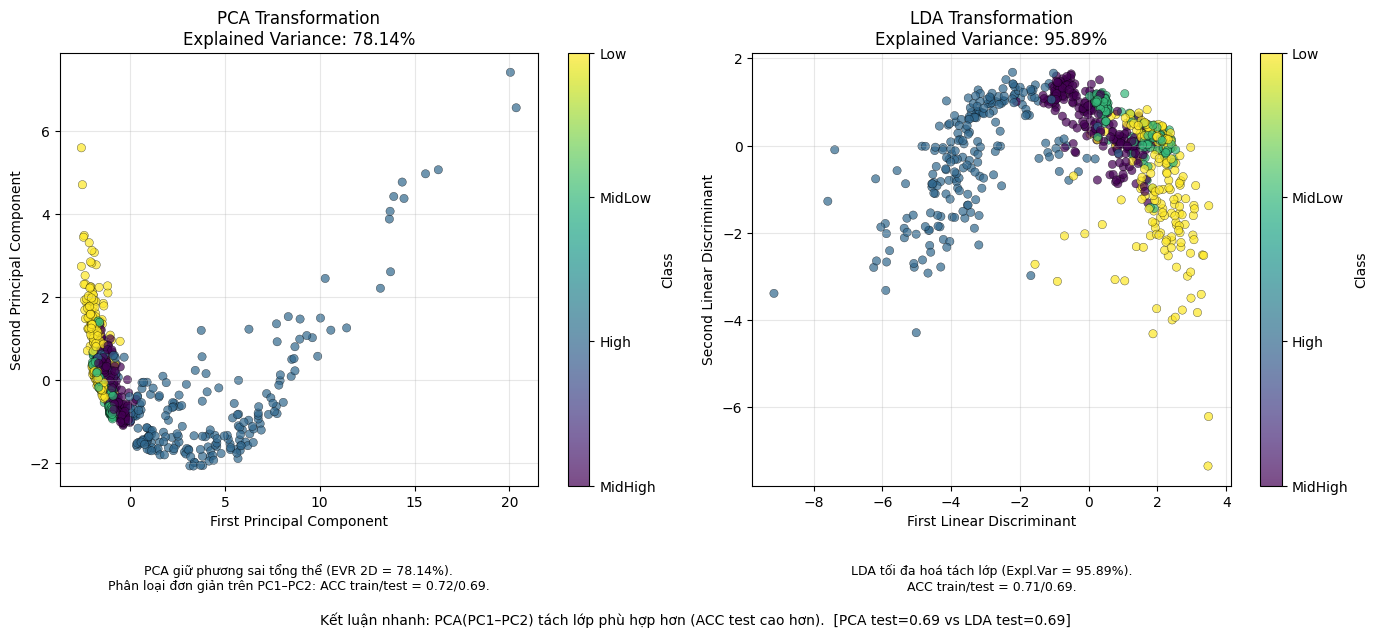

In [ ]:
# ACC cho LDA (trên không gian gốc đã scale)
lda_acc_train = lda_viz.score(X_train_scaled, y_train)
lda_acc_test  = lda_viz.score(X_test_scaled,  y_test)

# ACC cho PCA+LogReg dùng 2 PC để so sánh trực quan công bằng
log_pca = LogisticRegression(max_iter=1000)
log_pca.fit(X_train_pca, y_train)
pca_acc_train = log_pca.score(X_train_pca, y_train)
pca_acc_test  = log_pca.score(pca_viz.transform(X_test_scaled), y_test)

# Nhận xét ngắn cho từng subplot
note_pca = (
    f"PCA giữ phương sai tổng thể (EVR 2D = {evr_pca:.2%}).\n"
    f"Phân loại đơn giản trên PC1–PC2: ACC train/test = "
    f"{pca_acc_train:.2f}/{pca_acc_test:.2f}."
)
note_lda = (
    ("LDA tối đa hoá tách lớp" + (f" (Expl.Var = {evr_lda_sum:.2%})" if not np.isnan(evr_lda_sum) else "")) +
    f".\nACC train/test = {lda_acc_train:.2f}/{lda_acc_test:.2f}."
)

# Ghi chú ngay dưới mỗi subplot
ax1.annotate(note_pca, xy=(0.5, -0.18), xycoords="axes fraction",
             ha="center", va="top", fontsize=9)
ax2.annotate(note_lda, xy=(0.5, -0.18), xycoords="axes fraction",
             ha="center", va="top", fontsize=9)

# Kết luận ngắn toàn hình
better = "LDA" if lda_acc_test >= pca_acc_test else "PCA(PC1–PC2)"
why = "ACC test cao hơn" if lda_acc_test != pca_acc_test else "hiệu năng tương đương (dựa trên ACC test)"
summary = (
    f"Kết luận : {better} tách lớp phù hợp hơn ({why}).  "
    f"[PCA test={pca_acc_test:.2f} vs LDA test={lda_acc_test:.2f}]"
)
fig.text(0.5, -0.03, summary, ha="center", va="top", fontsize=10)

# Canh lề dưới đủ chỗ cho ghi chú
plt.subplots_adjust(bottom=0.28)
plt.tight_layout()
plt.show()
